In [1]:
%matplotlib inline

## Loading Dependencies

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# Load Data

**TODO**: Split Training and Validation Data

In [3]:
from torch.utils.data.dataset import Dataset
from glob import glob
from tqdm import tqdm
from PIL import Image

class BirdDataset(Dataset):
    """Dataset wrapping images and target labels
    """
    def __init__(self, image_path_pattern, transform=None): 
        self.transform = transform
        X_train, y_train = self.__get_data(image_path_pattern)
        #X_train, y_train = shuffle(X_train, y_train)
        
        self.X_train = X_train
        self.y_train = np.array(self.__one_hot(y_train), np.int64) 
        
    def __get_data(self, image_path_pattern):
        all_img_paths = glob(image_path_pattern)
        X, y = [], []   
        for img_name in tqdm(all_img_paths):
            bird_novice_name = img_name.split('/')[-2].split('_')[-1]
            if any(char.isdigit() for char in bird_novice_name):
                continue
            img = Image.open(img_name)
            img = img.convert('RGB') 
            X.append(img)
            y.append(bird_novice_name)
        return X, y  
    
    def __one_hot(self, y):
        self.classes = list(set(y))
        self.mapping = {self.classes[i]:i for i in range(len(self.classes))}
        y_out = [self.mapping[i] for i in y]
        return y_out      

    def __getitem__(self, index):
        img = self.X_train[index]
        if self.transform is not None:
            img = self.transform(img)  
        return img, self.y_train[index]

    def __len__(self):
        return len(self.X_train)

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {'train': BirdDataset('images/*/*.jpg', data_transforms['train']),
                 'val': BirdDataset('images/*/*.jpg', data_transforms['val'])}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

100%|██████████| 6033/6033 [00:05<00:00, 1024.58it/s]


In [5]:
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [6]:
use_gpu

True

Visualizing a few training images so as to understand the data augmentations.

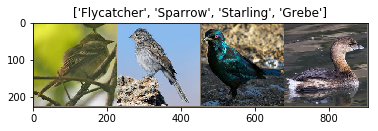

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# VGG Net

In [63]:
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

In [64]:
model_conv = torchvision.models.vgg16(pretrained=True)
model_conv = model_conv.features

for param in model_conv.parameters():
    param.requires_grad = False
    
model_conv.add_module("AvgPool", nn.AvgPool2d(7, stride=1))
model_conv.add_module("flatten", Flatten())
model_conv.add_module("fc", nn.Linear(512, len(class_names)))

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [65]:
model_conv

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1

# Train and evaluate

In [67]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6892 Acc: 0.8309
val Loss: 0.6867 Acc: 0.8305

Epoch 1/24
----------
train Loss: 0.6850 Acc: 0.8330
val Loss: 0.6867 Acc: 0.8304

Epoch 2/24
----------
train Loss: 0.6900 Acc: 0.8278
val Loss: 0.6866 Acc: 0.8304

Epoch 3/24
----------
train Loss: 0.6866 Acc: 0.8293
val Loss: 0.6866 Acc: 0.8304

Epoch 4/24
----------
train Loss: 0.6867 Acc: 0.8304
val Loss: 0.6866 Acc: 0.8304

Epoch 5/24
----------
train Loss: 0.6857 Acc: 0.8314
val Loss: 0.6866 Acc: 0.8304

Epoch 6/24
----------
train Loss: 0.6867 Acc: 0.8302
val Loss: 0.6866 Acc: 0.8304

Epoch 7/24
----------
train Loss: 0.6876 Acc: 0.8286
val Loss: 0.6866 Acc: 0.8304

Epoch 8/24
----------
train Loss: 0.6890 Acc: 0.8307
val Loss: 0.6866 Acc: 0.8304

Epoch 9/24
----------
train Loss: 0.6873 Acc: 0.8317
val Loss: 0.6866 Acc: 0.8304

Epoch 10/24
----------
train Loss: 0.6884 Acc: 0.8290
val Loss: 0.6866 Acc: 0.8304

Epoch 11/24
----------
train Loss: 0.6891 Acc: 0.8284
val Loss: 0.6866 Acc: 0.8304

Ep

# Classmap Generation

In [68]:
finalconv_name = '30'
model_conv.cpu().eval()

# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
    
model_conv._modules.get(finalconv_name).register_forward_hook(hook_feature)

params = list(model_conv.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

In [69]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [70]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.CenterCrop((224,224)),
   transforms.ToTensor(),
   normalize
])

In [71]:
import cv2
def display_heatmap(path):
    global features_blobs
    img_pil = Image.open(path)
    img_pil.save('test.jpg')

    img_tensor = preprocess(img_pil)
    img_variable = Variable(img_tensor.unsqueeze(0))
    features_blobs.clear()
    logit = model_conv(img_variable)


    from torch.nn import functional as F
    h_x = F.softmax(logit).data.squeeze()
    probs, idx = h_x.sort(0, True)

    # output the prediction
    for i in range(0, 4):
        print('{:.3f} -> {}'.format(probs[i], class_names[idx[i]]))

    CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

    # render the CAM and output
    print('output CAM.jpg for the top1 prediction: %s'%class_names[idx[0]])
    img = cv2.imread('test.jpg')
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + img * 0.5
    cv2.imwrite('CAM.jpg', result)

    out = Image.open("CAM.jpg")
    return out

# Sample Classmaps

0.485 -> Sparrow
0.159 -> Warbler
0.127 -> Nuthatch
0.054 -> Grosbeak
output CAM.jpg for the top1 prediction: Sparrow


/raid/sbinnani/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


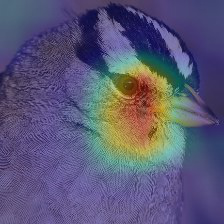

In [72]:
display_heatmap('images/132.White_crowned_Sparrow/White_crowned_Sparrow_0004_2232004154.jpg')

0.990 -> Sparrow
0.005 -> Pipit
0.004 -> Thrasher
0.001 -> Waterthrush
output CAM.jpg for the top1 prediction: Sparrow


/raid/sbinnani/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


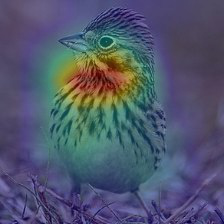

In [73]:
display_heatmap('images/131.Vesper_Sparrow/Vesper_Sparrow_0004_1769798864.jpg')

0.995 -> Woodpecker
0.001 -> Kingfisher
0.001 -> Creeper
0.001 -> Flicker
output CAM.jpg for the top1 prediction: Woodpecker


/raid/sbinnani/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


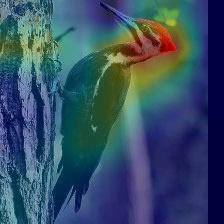

In [74]:
display_heatmap('images/188.Pileated_Woodpecker/Pileated_Woodpecker_0006_2443246132.jpg')

0.548 -> Woodpecker
0.171 -> Kingfisher
0.049 -> Shrike
0.024 -> Warbler
output CAM.jpg for the top1 prediction: Woodpecker


/raid/sbinnani/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


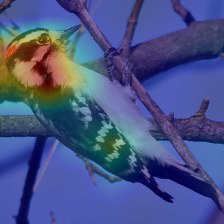

In [75]:
display_heatmap('images/192.Downy_Woodpecker/Downy_Woodpecker_0009_2995605268.jpg')

In [1]:
import torchvision

In [5]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b